In [1]:
import pandas as pd 


/Users/apuri/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [216]:
df = pd.read_pickle('df-5-3-5pm.pkl')

In [99]:
import numpy as np 
from scipy.stats import gaussian_kde, entropy


def divergence_gaussian_kde(kde_p, kde_q, samples=1000):
    sample_1 = np.linspace(0.05, 0.8, samples)
    p = kde_p(sample_1) + 1e-8
    q = kde_q(sample_1) + 1e-8
    m = (p + q) / 2
    divergence = (entropy(p, m) + entropy(q, m)) / 2
    return divergence


def KL_divergence(data, k, real_distribution):
    window_shape = k
    neighbors_matrix = np.lib.stride_tricks.sliding_window_view(data, window_shape)

    # Preallocate the kde_list array
    kde_list = np.empty(neighbors_matrix.shape[0], dtype=object)

    # Populate the kde_list array with gaussian_kde objects
    for i in range(neighbors_matrix.shape[0]):
        kde_list[i] = gaussian_kde(neighbors_matrix[i])

    # Calculate KL divergence values in a vectorized manner
    kl_values = np.array([divergence_gaussian_kde(kde_list[i], real_distribution[i + k//2])
                          for i in range(0, kde_list.shape[0], 500)])

    # Sum the KL values to obtain the final result
    KL_sum = np.sum(kl_values)

    return KL_sum

In [62]:

# Filter instances with alpha=0.4 and hidden sizes 85, 210, and 485
filtered_df = df[(df['alpha'] == 0.4) & (df['hidden_size'].isin([85, 210, 485]))]

# Separate data by hidden_size
df_85 = filtered_df[filtered_df['hidden_size'] == 85].iloc[:, 3:]
df_210 = filtered_df[filtered_df['hidden_size'] == 210].iloc[:, 3:]
df_485 = filtered_df[filtered_df['hidden_size'] == 485].iloc[:, 3:]

# Function to calculate gaussian_kde for each column
def calculate_gaussian_kde(df):
    kde_list = []
    for column in df.columns:
        kde_list.append(gaussian_kde(df[column]))
    return kde_list

# Calculate gaussian_kde for each hidden_size
kde_85 = calculate_gaussian_kde(df_85)
kde_210 = calculate_gaussian_kde(df_210)
kde_485 = calculate_gaussian_kde(df_485)

In [46]:
# Function to get the first instance of the 100k floats for each hidden_size
def get_first_instance(df):
    return np.array(df.iloc[0])

# Get the first instance for each hidden_size
first_instance_85 = get_first_instance(df_85)
first_instance_210 = get_first_instance(df_210)
first_instance_485 = get_first_instance(df_485)

In [91]:
kde_85, kde_210, kde_485 = np.array(kde_85), np.array(kde_210), np.array(kde_485)

In [103]:
for k in range(3,101, 2):
    print(k)
    x = KL_divergence(first_instance_85, k, kde_85)
    y = KL_divergence(first_instance_210, k, kde_210)
    z = KL_divergence(first_instance_485, k, kde_485)
    print(x+y+z)
    print('---------------------------')
#k=19 optimal for minimizing KL divergence 


1


ValueError: `dataset` input should have multiple elements.

In [204]:
def bootstrapped_log_prob(data, target, k):
    assert k % 2 == 1
    assert data.shape == target.shape

    window_shape = (1, k)
    neighbors_matrix = np.lib.stride_tricks.sliding_window_view(data, window_shape)

    pdf = np.zeros(target.shape)
    for i in range(neighbors_matrix.shape[0]):
        print(i)
        for j in range(neighbors_matrix.shape[1]):
            window_data = neighbors_matrix[i, j, :].squeeze()
            kde = gaussian_kde(window_data)
            pdf[i, j] = kde.evaluate(target[i, j + k//2])

    pdf[pdf == 0] = np.finfo(float).eps
    log_probs = np.log(pdf)
    return np.sum(log_probs)

In [177]:
THROWOUT_DATA = 100


In [178]:
df_04 = df[df['alpha']==0.4]

# drop duplicates based on hidden_size
df_04 = df_04.drop_duplicates(subset=['hidden_size'])

# extract the float values
values_04 = df_04.iloc[:, THROWOUT_DATA + 3:].values.astype(float)

# create a dictionary that maps each row index to the hidden_size associated with it
size_dict_04 = {i: size for i, size in enumerate(df_04['hidden_size'])}

In [191]:
def histogram_estimator(data, target, k, num_bins=10):
    assert k % 2 == 1
    assert data.shape == target.shape
    
    window_shape = (1, k)
    neighbors_matrix = np.lib.stride_tricks.sliding_window_view(data, window_shape)

    # Compute the min and max values for bin edges
    data_min, data_max = np.min(data), np.max(data)

    # Compute the bin edges
    bin_edges = np.linspace(data_min, data_max, num_bins + 1)

    # Digitize the data to find bin indices for each element in the sliding windows
    bin_indices = np.digitize(neighbors_matrix, bin_edges) - 1
    
    # Define a function to compute the histogram for each window
    def window_histogram(window):
        hist, _ = np.histogram(window, bins=bin_edges)
        return hist

    # Compute histograms for each window
    histogram_matrix = np.apply_along_axis(window_histogram, 2, neighbors_matrix)

    # Normalize the histograms to obtain a density estimate
    density_estimate = histogram_matrix / (np.sum(histogram_matrix, axis=2, keepdims=True) + np.finfo(float).eps)

    # Find the bin indices for the target values
    target_bin_indices = np.digitize(target, bin_edges) - 1

    # Get the density estimates from the histogram matrix for the target values
    pdf = density_estimate[np.arange(target.shape[0]).reshape(-1, 1), np.arange(target.shape[1] - k + 1), target_bin_indices[:, k//2]]

    # Ensure that the probability is never 0
    pdf[pdf == 0] = np.finfo(float).eps

    log_probs = np.log(pdf)
    return np.sum(log_probs)

In [192]:
def no_cross_term(A, B, E, alpha, beta, size_keys, size_values, values_shape):
    i_indices, j_indices = np.meshgrid(np.arange(values_shape[0]), np.arange(values_shape[1]), indexing='ij')
    N = np.interp(i_indices, size_keys, size_values) * 602
    D = (j_indices + THROWOUT_DATA) * 20000
    return (E + A * (N ** (-1 * alpha)) + B * (D ** (-1 * beta)))

def cross_term(A, B, E, alpha, beta, F, gamma, kappa, size_keys, size_values, values_shape):
    i_indices, j_indices = np.meshgrid(np.arange(values_shape[0]), np.arange(values_shape[1]), indexing='ij')
    N = np.interp(i_indices, size_keys, size_values) * 602
    D = (j_indices + THROWOUT_DATA) * 20000
    return (E + A * (N ** (-1 * alpha)) + B * (D ** (-1 * beta)) + F * (N ** (-1 * gamma)) * (D ** (-1 * kappa)))

def bootstrap_no_cross(A, B, E, alpha, beta, values, size_dict):
    size_keys, size_values = np.array(list(size_dict.keys())), np.array(list(size_dict.values()))
    predictions = no_cross_term(A, B, E, alpha, beta, size_keys, size_values, values.shape)
    errors = values - predictions
    return -1*histogram_estimator(errors, errors, 19)

def bootstrap_cross(A, B, E, alpha, beta, F, gamma, kappa, values, size_dict):
    size_keys, size_values = np.array(list(size_dict.keys())), np.array(list(size_dict.values()))
    predictions = cross_term(A, B, E, alpha, beta, F, gamma, kappa, size_keys, size_values, values.shape)
    errors = values - predictions
    return -1*histogram_estimator(errors, errors, 19)

def OLS_no_cross(A, B, E, alpha, beta, values, size_dict):
    size_keys, size_values = np.array(list(size_dict.keys())), np.array(list(size_dict.values()))
    predictions = no_cross_term(A, B, E, alpha, beta, size_keys, size_values, values.shape)
    errors = values - predictions
    return np.sum(errors ** 2)

def OLS_cross(A, B, E, alpha, beta, F, gamma, kappa, values, size_dict):
    size_keys, size_values = np.array(list(size_dict.keys())), np.array(list(size_dict.values()))
    predictions = cross_term(A, B, E, alpha, beta, F, gamma, kappa, size_keys, size_values, values.shape)
    errors = values - predictions
    return np.sum(errors ** 2)


In [181]:
from scipy.optimize import minimize
OLS_no_cross_results = minimize(lambda params : OLS_no_cross(*params,values_04,size_dict_04),[17, 2026, 0.1, 0.42, 0.54] ,bounds = [(1e-8,np.inf), (1e-8,np.inf), (0,np.inf), (1e-8,5), (1e-8,5)])
print(OLS_no_cross_results.x)

[1.69036189e+01 2.02595153e+03 0.00000000e+00 4.16771890e-01
 5.39633712e-01]


In [184]:
OLS_cross_results = minimize(lambda params: OLS_cross(*params, values_04, size_dict_04), [10,2000,0.1, 0.4, 0.3, 10, 0.2, 0.2], bounds = [(1e-8,np.inf), (1e-8,np.inf), (1e-8,np.inf), (1e-8,5), (1e-8,5), (1e-8,np.inf), (1e-8,5), (1e-8,5)])
print(OLS_cross_results.x)

[1.37749447e+01 2.38405483e+03 1.00000000e-08 4.18155118e-01
 5.53506502e-01 1.19599278e+01 3.74999541e-01 7.90865282e-02]


In [196]:
import matplotlib.pyplot as plt
# Assuming you already have the filtered_df DataFrame and df_85, df_210, and df_485 are created as you provided
# Calculate variance down each column
var_85 = df_85.var(axis=0).to_frame().T
var_210 = df_210.var(axis=0).to_frame().T
var_485 = df_485.var(axis=0).to_frame().T

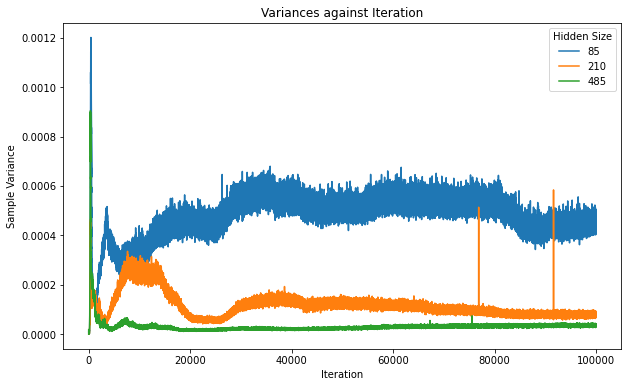

In [197]:
# Plot the variances
plt.figure(figsize=(10, 6))
plt.plot(var_85.columns, var_85.iloc[0], label="85")
plt.plot(var_210.columns, var_210.iloc[0], label="210")
plt.plot(var_485.columns, var_485.iloc[0], label="485")

# Set labels and title
plt.xlabel("Iteration")
plt.ylabel("Sample Variance")
plt.title("Variances against Iteration")

# Add legend
plt.legend(title="Hidden Size")

# Show the plot
plt.show()

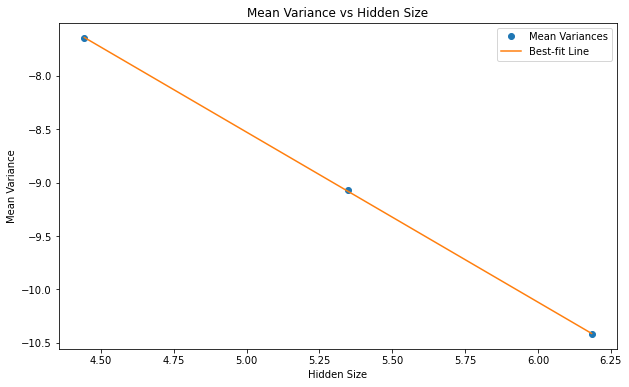

In [211]:
# Calculate the mean of the variances for each hidden size
mean_var_85 = var_85.mean(axis=1).values[0]
mean_var_210 = var_210.mean(axis=1).values[0]
mean_var_485 = var_485.mean(axis=1).values[0]

# Prepare data for plotting
hidden_sizes = np.log(np.array([85, 210, 485]))
mean_vars = np.log(np.array([mean_var_85, mean_var_210, mean_var_485]))

# Calculate the best-fit line
coefficients = np.polyfit(hidden_sizes, mean_vars, 1)
best_fit_line = np.poly1d(coefficients)

# Plot the mean variances against the hidden sizes
plt.figure(figsize=(10, 6))
plt.plot(hidden_sizes, mean_vars, 'o', label="Mean Variances")
plt.plot(hidden_sizes, best_fit_line(hidden_sizes), '-', label="Best-fit Line")

# Set labels and title
plt.xlabel("Hidden Size")
plt.ylabel("Mean Variance")
plt.title("Mean Variance vs Hidden Size")

# Add legend
plt.legend()

# Show the plot
plt.show()

In [199]:
OLS_no_cross_coeffs_0_4 = OLS_no_cross_results.x
OLS_cross_coeffs_0_4 = OLS_cross_results.x

size_keys_04, size_values_04 = np.array(list(size_dict_04.keys())), np.array(list(size_dict_04.values()))
residuals_no_cross = values_04 - no_cross_term(*OLS_no_cross_coeffs_0_4, size_keys_04, size_values_04, values_04.shape)
print(np.sum(residuals_no_cross))

-3584.5094636801045


In [200]:
residuals_cross = values_04 - cross_term(*OLS_cross_coeffs_0_4, size_keys_04, size_values_04, values_04.shape)
print(np.sum(residuals_cross))

-3462.0743785388267


In [206]:
residuals_cross_04_likelihood = bootstrapped_log_prob(residuals_cross, residuals_cross, 19)
print(residuals_cross_04_likelihood)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
12528836.954350756


In [208]:
print(np.mean(residuals_cross))
print(np.mean(residuals_no_cross))

-0.001332899968637417
-0.001380037523554364


In [217]:
df_02 = df[df['alpha']==0.2]

# drop duplicates based on hidden_size
df_02 = df_02.drop_duplicates(subset=['hidden_size'])

# extract the float values
values_02 = df_02.iloc[:, THROWOUT_DATA + 3:].values.astype(float)

# create a dictionary that maps each row index to the hidden_size associated with it
size_dict_02 = {i: size for i, size in enumerate(df_02['hidden_size'])}

In [218]:
OLS_no_cross_results_02 = minimize(lambda params : OLS_no_cross(*params,values_02,size_dict_02),[17, 2026, 0.1, 0.2, 0.2/1.2] ,bounds = [(1e-8,np.inf), (1e-8,np.inf), (0,np.inf), (1e-8,5), (1e-8,5)])
print(OLS_no_cross_results_02.x)

[1.58309093e+01 6.19689636e+02 0.00000000e+00 3.73576599e-01
 4.65688521e-01]


In [219]:
OLS_cross_results_02 = minimize(lambda params: OLS_cross(*params, values_02, size_dict_02), [10,2000,0.1, 0.2, 0.2/1.2, 10, 0.2, 0.2], bounds = [(1e-8,np.inf), (1e-8,np.inf), (1e-8,np.inf), (1e-8,5), (1e-8,5), (1e-8,np.inf), (1e-8,5), (1e-8,5)])
print(OLS_cross_results_02.x)

[1.12498866e+01 6.19804157e+02 1.00000000e-08 3.73583580e-01
 4.65699406e-01 4.58023059e+00 3.73543150e-01 1.00000000e-08]


In [221]:
OLS_no_cross_coeffs_02 = OLS_no_cross_results_02.x
OLS_cross_coeffs_02 = OLS_cross_results_02.x

size_keys_02, size_values_02 = np.array(list(size_dict_02.keys())), np.array(list(size_dict_02.values()))
residuals_no_cross_02 = values_02 - no_cross_term(*OLS_no_cross_coeffs_02, size_keys_02, size_values_02, values_02.shape)
print(np.mean(residuals_no_cross_02))
print(np.mean(residuals_no_cross_02 ** 2))
residuals_cross_02 = values_02 - cross_term(*OLS_cross_coeffs_02, size_keys_02, size_values_02, values_02.shape)
print(np.mean(residuals_cross_02))
print(np.mean(residuals_cross_02 ** 2))

-0.0004264807318696463
0.0003358480648907004
-0.00042567450209332017
0.00033584807708556805


In [222]:
residuals_no_cross_02_likelihood = bootstrapped_log_prob(residuals_no_cross_02, residuals_no_cross_02, 19)
print(residuals_no_cross_02_likelihood)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
7064598.452468417


In [ ]:
residuals_cross_02_likelihood = bootstrapped_log_prob(residuals_cross_02, residuals_cross_02, 19)
print(residuals_cross_02_likelihood)

In [223]:
df_08 = df[df['alpha']==0.8]
# drop duplicates based on hidden_size
df_08 = df_08.drop_duplicates(subset=['hidden_size'])

# extract the float values
values_08 = df_08.iloc[:, THROWOUT_DATA + 3:].values.astype(float)

# create a dictionary that maps each row index to the hidden_size associated with it
size_dict_08 = {i: size for i, size in enumerate(df_08['hidden_size'])}

In [224]:
OLS_no_cross_results_08 = minimize(lambda params : OLS_no_cross(*params,values_08,size_dict_08),[10, 2000, 0.1, 0.8, 0.8/1.8] ,bounds = [(1e-8,np.inf), (1e-8,np.inf), (0,np.inf), (1e-8,5), (1e-8,5)])
print(OLS_no_cross_results_08.x)

[9.00011600e+02 9.78305313e+03 0.00000000e+00 8.52590124e-01
 6.47383993e-01]


In [232]:
OLS_cross_results_08 = minimize(lambda params: OLS_cross(*params, values_08, size_dict_08), [900,1000,0.1, 0.8, 0.8/1.8, 1, 0.3, 0.3], bounds = [(1e-8,np.inf), (1e-8,np.inf), (1e-8,np.inf), (1e-8,5), (1e-8,5), (0,np.inf), (0,5), (0,np.inf)])
print(OLS_cross_results_08.x)

KeyboardInterrupt: 

In [229]:
OLS_no_cross_coeffs_08 = OLS_no_cross_results_08.x
OLS_cross_coeffs_08 = OLS_cross_results_08.x

size_keys_08, size_values_08 = np.array(list(size_dict_08.keys())), np.array(list(size_dict_08.values()))
residuals_no_cross_08 = values_08 - no_cross_term(*OLS_no_cross_coeffs_08, size_keys_08, size_values_08, values_08.shape)
print(np.mean(residuals_no_cross_08))
print(np.mean(residuals_no_cross_08 ** 2))
residuals_cross_08 = values_08 - cross_term(*OLS_cross_coeffs_08, size_keys_08, size_values_08, values_08.shape)
print(np.mean(residuals_cross_08))
print(np.mean(residuals_cross_08 ** 2))


-0.00021261261579971972
9.953218457162526e-05
5.543937219627888e-07
0.00012669702099506958


In [230]:
residuals_no_cross_08_likelihood = bootstrapped_log_prob(residuals_no_cross_08, residuals_no_cross_08, 19)
print(residuals_no_cross_08_likelihood)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
8293455.333301559
